<a href="https://colab.research.google.com/github/marklourenco/VGP-338-RPS-Model/blob/main/Lourenco_VGP338_Final_Assignmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q opendatasets

In [ ]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors",
    data_dir="data"
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marklourenco
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors


100%|██████████| 306M/306M [00:02<00:00, 120MB/s] 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def get_device():
    """
    Automatically detect and return the best available device
    Priority: CUDA > MPS > CPU
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✓ Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device("cpu")
        print("✓ Using CPU")

    return device

device = get_device()

✓ Using CUDA GPU: Tesla T4


In [ ]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from torch.utils.data import random_split

# Path to the actual image folder
data_dir = Path("data/rockpaperscissors/rps-cv-images")

# Load full dataset (no transform yet)
full_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=None
)

class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)

# Train/Test split (80/20)
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_subset, test_subset = random_split(
    full_dataset,
    [train_size, test_size]
)

# Apply transforms separately
train_subset.dataset.transform = train_transform
test_subset.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=32, shuffle=False)


Classes: ['paper', 'rock', 'scissors']


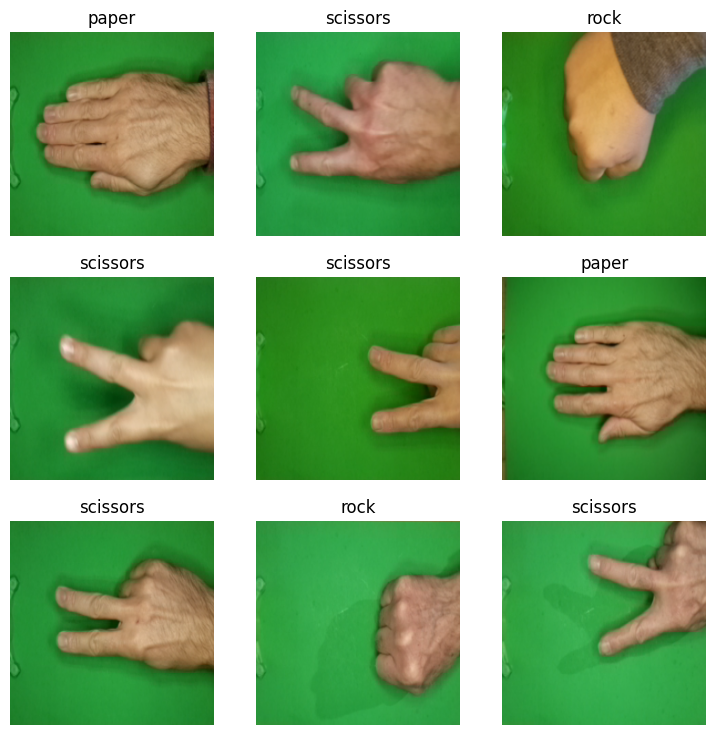

In [ ]:
def show_samples(dataset, class_names):
    plt.figure(figsize=(9,9))
    for i in range(9):
        # Ensure the dataset item is transformed before converting to numpy
        img, label = dataset[np.random.randint(len(dataset))]
        img = img.permute(1,2,0).numpy()
        img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.show()

show_samples(train_subset, class_names)

In [ ]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# Freeze all feature layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, test_loader, epochs=10):
    best_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | Accuracy: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "rps_resnet34_best.pth")
            print("Model saved")

train_model(model, train_loader, test_loader, epochs=10)

Epoch 1/10 | Loss: 30.473 | Accuracy: 95.89%
Model saved
Epoch 2/10 | Loss: 12.841 | Accuracy: 96.12%
Model saved
Epoch 3/10 | Loss: 9.164 | Accuracy: 96.80%
Model saved
Epoch 4/10 | Loss: 7.036 | Accuracy: 97.49%
Model saved
Epoch 5/10 | Loss: 6.167 | Accuracy: 98.40%
Model saved
Epoch 6/10 | Loss: 5.787 | Accuracy: 97.72%
Epoch 7/10 | Loss: 4.822 | Accuracy: 97.95%
Epoch 8/10 | Loss: 3.991 | Accuracy: 98.17%
Epoch 9/10 | Loss: 3.779 | Accuracy: 97.95%
Epoch 10/10 | Loss: 3.283 | Accuracy: 98.17%


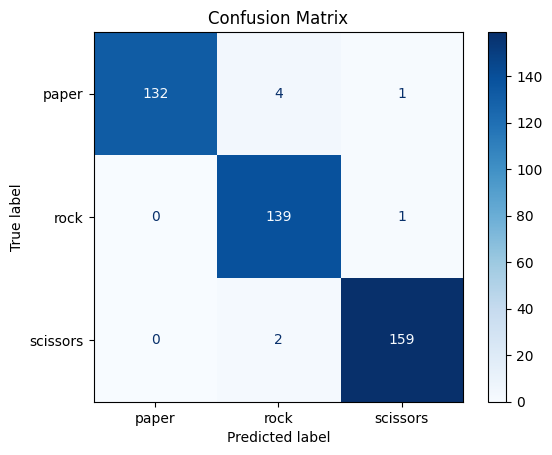

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "class_names": class_names
}, "rps_model_for_app.pth")

print("Model exported: rps_model_for_app.pth")

Model exported: rps_model_for_app.pth
